## Perturbative footprint study

### Imports

In [17]:
# Standard imports
import numpy as np
import shutil
from ruamel.yaml import YAML
import os
import matplotlib.pyplot as plt

# Cern modules
import fillingpatterns as fp
#import xmask as xm
import xtrack as xt

# Improve style
import seaborn as sns
sns.set_theme(style="whitegrid")


### Generate a machine with xmask from the appropriate configuration file

#### First create a proper configuration file

In [18]:
# Copy default configuration file for xmask, and target configuration file for pymask
shutil.copyfile('../modules/xmask/examples/hllhc15_collision/config.yaml', 'config_xm.yaml')
shutil.copyfile('/afs/cern.ch/work/c/cdroin/private/DA_study/master_study/opt_flathv_75_1500_withBB_chroma15_1p4_all_bunches/madx_001/config.yaml', 'config_pm.yaml')


# Read and mutate xmask config file
with open("config_xm.yaml", "r") as fid:
    config_xm_str = fid.read()

with open("config_pm.yaml", "r") as fid:
    config_pm_str = fid.read()
    
yaml = YAML()
config_pm = yaml.load(config_pm_str)
config_xm = yaml.load(config_xm_str)

# Hardcode optics configuration files as they can't be ported directly
config_xm['config_mad']['links']['acc-models-lhc'] = '/afs/cern.ch/eng/lhc/optics/HLLHCV1.5'
config_xm['config_mad']['optics_file'] = 'acc-models-lhc/flatcc/opt_flathv_75_180_1500_thin.madx'
config_xm['config_knobs_and_tuning']['closed_orbit_correction']['lhcb1'] = '../modules/tools/corr_co_lhcb1.json'
config_xm['config_knobs_and_tuning']['closed_orbit_correction']['lhcb2'] = '../modules/tools/corr_co_lhcb2.json'

# Mutate optics and check config
config_xm['config_mad']['enable_imperfections'] = config_pm['enable_imperfections']
config_xm['config_mad']['enable_knob_synthesis'] = config_pm['enable_knob_synthesis']
config_xm['config_mad']['ver_hllhc_optics'] = float(config_pm['optics_version'])
config_xm['config_mad']['pars_for_imperfections'] = config_pm['pars_for_imperfections']

# Mutate beam config
config_xm['config_mad']['beam_config']['lhcb1']['beam_energy_tot'] = config_pm['beam_energy_tot']
config_xm['config_mad']['beam_config']['lhcb2']['beam_energy_tot'] = config_pm['beam_energy_tot']

# Mutate beambeam parameters
config_xm['config_beambeam']['nemitt_x'] = config_pm['beam_norm_emit_x']*1e-6
config_xm['config_beambeam']['nemitt_y'] = config_pm['beam_norm_emit_y']*1e-6
config_xm['config_beambeam']['sigma_z'] = config_pm['beam_sigt']
config_xm['config_beambeam']['num_particles_per_bunch'] = config_pm['beam_npart']
config_xm['config_beambeam']['num_particles_per_bunch'] = config_pm['beam_npart']
for i, ip in enumerate(['ip1', 'ip2', 'ip5', 'ip8']):
    config_xm['config_beambeam']['num_long_range_encounters_per_side'][ip] = config_pm['beambeam_config']['numberOfLRPerIRSide'][i]
config_xm['config_beambeam']['num_slices_head_on'] = config_pm['beambeam_config']['numberOfHOSlices']
config_xm['config_beambeam']['bunch_spacing_buckets'] = config_pm['beambeam_config']['bunch_spacing_buckets']

# Mutate tunes and chromaticities (assume same for both beams, since not settable in pymask)
config_xm['config_knobs_and_tuning']['qx']['lhcb1'] = config_pm['qx0']
config_xm['config_knobs_and_tuning']['qx']['lhcb2'] = config_pm['qx0']
config_xm['config_knobs_and_tuning']['qy']['lhcb1'] = config_pm['qy0']
config_xm['config_knobs_and_tuning']['qy']['lhcb2'] = config_pm['qy0']
config_xm['config_knobs_and_tuning']['dqx']['lhcb1'] = config_pm['chromaticity_x']
config_xm['config_knobs_and_tuning']['dqx']['lhcb2'] = config_pm['chromaticity_x']
config_xm['config_knobs_and_tuning']['dqy']['lhcb1'] = config_pm['chromaticity_y']
config_xm['config_knobs_and_tuning']['dqy']['lhcb2'] = config_pm['chromaticity_y']

# Mutate knobs
for knob in config_pm['knob_settings']:
    if knob in config_xm['config_knobs_and_tuning']['knob_settings']:
        config_xm['config_knobs_and_tuning']['knob_settings'][knob] = config_pm['knob_settings'][knob]
    else:
        print(f"Knob {knob} not found in xmask config file. Beind added now.")
        config_xm['config_knobs_and_tuning']['knob_settings'][knob] = config_pm['knob_settings'][knob]

# Mutate RF voltage and octupole current
config_xm['config_knobs_and_tuning']['knob_settings']['vrf400'] = config_pm['vrf_total']
config_xm['config_knobs_and_tuning']['knob_settings']['i_oct_b1'] = config_pm['oct_current']
config_xm['config_knobs_and_tuning']['knob_settings']['i_oct_b2'] = config_pm['oct_current']


# Artificially implement end of luminosity levelling
config_xm['config_knobs_and_tuning']['knob_settings']['on_sep8'] = 0.0
config_xm['config_knobs_and_tuning']['knob_settings']['on_sep8h'] = -0.01745641501719127
config_xm['config_knobs_and_tuning']['knob_settings']['on_sep8v'] = 0.01371863979152592
config_xm['config_knobs_and_tuning']['knob_settings']['on_x8'] = 0.0
config_xm['config_knobs_and_tuning']['knob_settings']['on_x8h'] = 0.0
config_xm['config_knobs_and_tuning']['knob_settings']['on_x8v'] = 170.0
config_xm['config_knobs_and_tuning']['knob_settings']['on_sep2'] = 0.1443593672910653
 

# ! WARNING. AT THIS POINT:
# ! - Coupling is missing
# ! - bunch-by-bunch and filling schemes are missing


# Write config file
with open("config_xm.yaml", "w") as fid:
    yaml.dump(config_xm, fid)


Knob on_x8h not found in xmask config file. Beind added now.
Knob on_x8v not found in xmask config file. Beind added now.
Knob on_sep8h not found in xmask config file. Beind added now.
Knob on_sep8v not found in xmask config file. Beind added now.


#### Build machine

In [19]:
REBUILD = False
if REBUILD:
    os.system("python build_machine.py")
collider = xt.Multiline.from_json("output/collider_tuned_bb_on.json")
collider.build_trackers()

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...


37417541c67f421eb1c1bcc502b609a9.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 37417541c67f421eb1c1bcc502b609a9.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


cec6d6bd9fae4d8e9a58ce6be9f05ee9.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from cec6d6bd9fae4d8e9a58ce6be9f05ee9.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


### Correct bbb schedule

In [20]:
# Get BB schedule
fname = "filling_scheme/8b4e_1972b_1960_1178_1886_224bpi_12inj_800ns_bs200ns.json"
patt = fp.FillingPattern.from_json(fname)

# Compute bb schedule
patt.compute_beam_beam_schedule(n_lr_per_side=25)
bbs_b1 = patt.b1.bb_schedule
bbs_b2 = patt.b2.bb_schedule

# Get list of bunches
bbs_b1

Computing collision schedules...
Done Beam 1
Done Beam 2


,HO partner in ALICE,# of LR in ALICE,BB partners in ALICE,Positions in ALICE,HO partner in ATLAS/CMS,# of LR in ATLAS/CMS,BB partners in ATLAS/CMS,Positions in ATLAS/CMS,HO partner in LHCB,# of LR in LHCB,BB partners in LHCB,Positions in LHCB,collides in ATLAS/CMS,collides in ALICE,collides in LHCB
12,903.0,23,"[879.0, 880.0, 881.0, 882.0, 883.0, 884.0, 885...","[-24.0, -23.0, -22.0, -21.0, -20.0, -19.0, -18...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, ...",2682.0,29,"[2657.0, 2658.0, 2659.0, 2660.0, 2661.0, 2662....","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",False,True,True
13,904.0,23,"[879.0, 880.0, 881.0, 882.0, 883.0, 884.0, 885...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0,...",2683.0,28,"[2658.0, 2659.0, 2660.0, 2661.0, 2662.0, 2667....","[-25.0, -24.0, -23.0, -22.0, -21.0, -16.0, -15...",False,True,True
14,905.0,22,"[880.0, 881.0, 882.0, 883.0, 884.0, 885.0, 886...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0...",2684.0,27,"[2659.0, 2660.0, 2661.0, 2662.0, 2667.0, 2668....","[-25.0, -24.0, -23.0, -22.0, -17.0, -16.0, -15...",False,True,True
15,906.0,21,"[881.0, 882.0, 883.0, 884.0, 885.0, 886.0, 891...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9....",2685.0,26,"[2660.0, 2661.0, 2662.0, 2667.0, 2668.0, 2669....","[-25.0, -24.0, -23.0, -18.0, -17.0, -16.0, -15...",False,True,True
16,907.0,20,"[882.0, 883.0, 884.0, 885.0, 886.0, 891.0, 892...","[-25.0, -24.0, -23.0, -22.0, -21.0, -16.0, -15...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-16.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10...",2686.0,25,"[2661.0, 2662.0, 2667.0, 2668.0, 2669.0, 2670....","[-25.0, -24.0, -19.0, -18.0, -17.0, -16.0, -15...",False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3438,765.0,23,"[741.0, 742.0, 743.0, 744.0, 745.0, 746.0, 747...","[-24.0, -23.0, -22.0, -21.0, -20.0, -19.0, -18...",3438.0,21,"[3413.0, 3414.0, 3415.0, 3416.0, 3417.0, 3418....","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",2544.0,21,"[2519.0, 2520.0, 2521.0, 2522.0, 2523.0, 2524....","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",True,True,True
3439,766.0,23,"[741.0, 742.0, 743.0, 744.0, 745.0, 746.0, 747...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",3439.0,20,"[3414.0, 3415.0, 3416.0, 3417.0, 3418.0, 3423....","[-25.0, -24.0, -23.0, -22.0, -21.0, -16.0, -15...",2545.0,20,"[2520.0, 2521.0, 2522.0, 2523.0, 2524.0, 2529....","[-25.0, -24.0, -23.0, -22.0, -21.0, -16.0, -15...",True,True,True
3440,767.0,22,"[742.0, 743.0, 744.0, 745.0, 746.0, 747.0, 748...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",3440.0,19,"[3415.0, 3416.0, 3417.0, 3418.0, 3423.0, 3424....","[-25.0, -24.0, -23.0, -22.0, -17.0, -16.0, -15...",2546.0,19,"[2521.0, 2522.0, 2523.0, 2524.0, 2529.0, 2530....","[-25.0, -24.0, -23.0, -22.0, -17.0, -16.0, -15...",True,True,True
3441,768.0,21,"[743.0, 744.0, 745.0, 746.0, 747.0, 748.0, 753...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",3441.0,18,"[3416.0, 3417.0, 3418.0, 3423.0, 3424.0, 3425....","[-25.0, -24.0, -23.0, -18.0, -17.0, -16.0, -15...",2547.0,18,"[2522.0, 2523.0, 2524.0, 2529.0, 2530.0, 2531....","[-25.0, -24.0, -23.0, -18.0, -17.0, -16.0, -15...",True,True,True


In [21]:
# Take care of LR elements
for ip, name_position in zip([1, 2, 5, 8], ["Positions in ATLAS/CMS", "Positions in ALICE", "Positions in ATLAS/CMS", "Positions in LHCB"]):
    
    idx_elements_b1 = bbs_b1.loc[23][name_position]
    #idx_elements_b2 = bbs_b2.loc[23][name_position]

    # Deactivate elements that shouldn't be here in beam 1
    for i, x in enumerate(collider.lhcb1.element_names):
        # print(collider.lhcb1[x].to_dict())
        # First look for bb_elements for current IP        
        if 'bb_lr.l' + str(ip) in x or 'bb_lr.r' + str(ip) in x:
            # Then only keep elements corresponding to the current IP
            pos = int(x.split('_')[2])
            if 'l' in x.split('lr.')[1]:
                pos = -pos
            if pos not in idx_elements_b1:
                collider.lhcb1.element_refs[x].scale_strength = 0

    # # Same with beam 2
    # for i, x in enumerate(collider.lhcb2.element_names):
    #     if 'bb_lr.l' + str(ip) in x or 'bb_lr.r' + str(ip) in x:
    #         pos = int(x.split('_')[2])
    #         if 'l' in x.split('lr.')[1]:
    #             pos = -pos
    #         if pos not in idx_elements_b2:
    #             collider.lhcb2.element_refs[x].scale_strength = 0
        

In [22]:
# Take care of HO elements
for ip, bool_collide in zip([1, 2, 5, 8], ['collides in ATLAS/CMS', 'collides in ALICE', 'collides in ATLAS/CMS', 'collides in LHCB']):
    collide_b1 = bbs_b1.loc[23][bool_collide]
    #collide_b2 = bbs_b2.loc[23][bool_collide]

    # Deactivate elements that shouldn't be here in beam 1
    for i, x in enumerate(collider.lhcb1.element_names):
        # First look for bb_elements
        if ('bb_ho.l' + str(ip) in x or 'bb_ho.r' + str(ip) in x or 'bb_ho.c' + str(ip) in x) and not collide_b1:
            collider.lhcb1.element_refs[x].scale_strength = 0

    # # Same with beam 2
    # for i, x in enumerate(collider.lhcb2.element_names):
    #     if ('bb_ho.l' + str(ip) in x or 'bb_ho.r' + str(ip) in x or 'bb_ho.c' + str(ip) in x) and not collide_b2:
    #         collider.lhcb2.element_refs[x].scale_strength = 0
    


In [23]:
for i, x in enumerate(collider.lhcb1.element_names):
    if 'bb_ho' in x or 'bb_lr' in x:
        print(x, collider.lhcb1.element_refs[x].scale_strength._value)

bb_lr.l5b1_25 0.0
bb_lr.l5b1_24 0.0
bb_lr.l5b1_23 1.0
bb_lr.l5b1_22 1.0
bb_lr.l5b1_21 1.0
bb_lr.l5b1_20 1.0
bb_lr.l5b1_19 1.0
bb_lr.l5b1_18 1.0
bb_lr.l5b1_17 1.0
bb_lr.l5b1_16 1.0
bb_lr.l5b1_15 1.0
bb_lr.l5b1_14 1.0
bb_lr.l5b1_13 1.0
bb_lr.l5b1_12 1.0
bb_lr.l5b1_11 0.0
bb_lr.l5b1_10 0.0
bb_lr.l5b1_09 0.0
bb_lr.l5b1_08 0.0
bb_lr.l5b1_07 0.0
bb_lr.l5b1_06 0.0
bb_lr.l5b1_05 0.0
bb_lr.l5b1_04 0.0
bb_lr.l5b1_03 0.0
bb_lr.l5b1_02 0.0
bb_lr.l5b1_01 0.0
bb_ho.l5b1_05 0.0
bb_ho.l5b1_04 0.0
bb_ho.l5b1_03 0.0
bb_ho.l5b1_02 0.0
bb_ho.l5b1_01 0.0
bb_ho.c5b1_00 0.0
bb_ho.r5b1_01 0.0
bb_ho.r5b1_02 0.0
bb_ho.r5b1_03 0.0
bb_ho.r5b1_04 0.0
bb_ho.r5b1_05 0.0
bb_lr.r5b1_01 0.0
bb_lr.r5b1_02 0.0
bb_lr.r5b1_03 0.0
bb_lr.r5b1_04 0.0
bb_lr.r5b1_05 0.0
bb_lr.r5b1_06 0.0
bb_lr.r5b1_07 0.0
bb_lr.r5b1_08 0.0
bb_lr.r5b1_09 0.0
bb_lr.r5b1_10 0.0
bb_lr.r5b1_11 0.0
bb_lr.r5b1_12 0.0
bb_lr.r5b1_13 0.0
bb_lr.r5b1_14 0.0
bb_lr.r5b1_15 0.0
bb_lr.r5b1_16 0.0
bb_lr.r5b1_17 0.0
bb_lr.r5b1_18 0.0
bb_lr.r5b1_19 0.0
bb_lr.r5b1

## Plot footprint

Coupling correction due to the lattice (```delta_cmr``` and ```delta_cmi``` in pymask) are ignored as they're not very relevant for the coupling study.

Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.


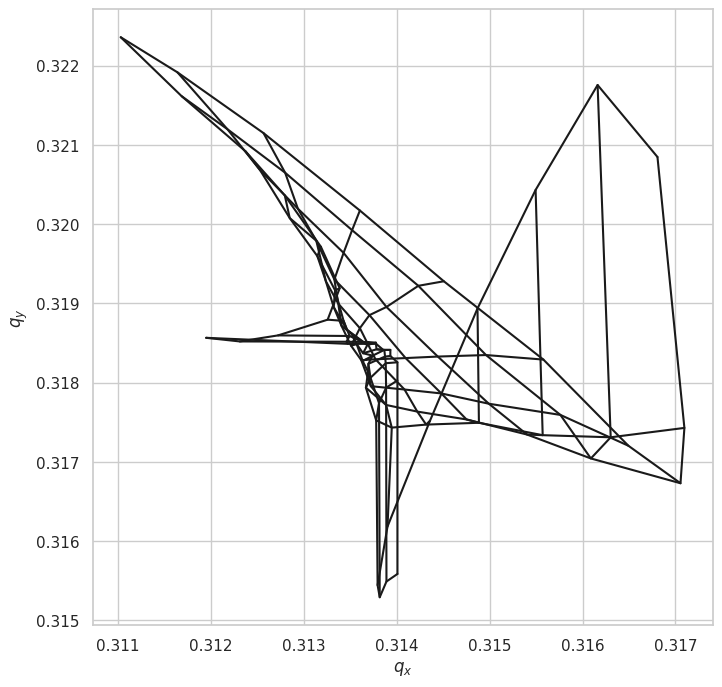

In [24]:
#collider.vars['c_minus_re_b1'] = 0
#collider["lhcb1"].twiss()

# Plot footprint
fp_polar_xm = collider["lhcb1"].get_footprint(
    nemitt_x=2.5e-6,
    nemitt_y=2.5e-6,
    linear_rescale_on_knobs=[xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.1/2)],
)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fp_polar_xm.plot(ax=ax, label="no rescale bb")
plt.show()